<a href="https://colab.research.google.com/github/Bhavya171/LLM_From_Scratch/blob/main/LLM_Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3

We have to fine tune any model on any dataset for instruction following

## Importing libraries

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_dataset
import torch

## Loading the dataset:

I have used Databricks dolly 15k datase. The sample entry of the dataset is here.
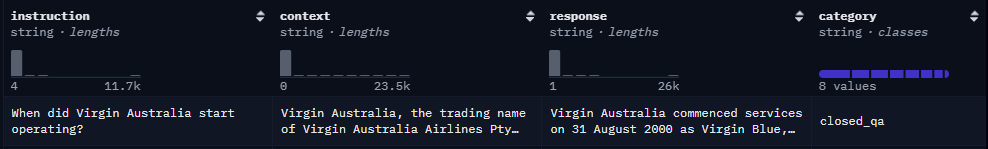

In [ ]:
# Load dataset
dataset = load_dataset("databricks/databricks-dolly-15k", split="train[:1000]")


## Loading the model:

I have taken flan-t5 model by google which i have finetuned for instruction following

In [ ]:
# Load tokenizer and model
model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

## Prompt Formatting:

Format Function (format_prompt): Converts each example into a structured prompt with Instruction, optional Input (context), and Output: to standardize the format for model training.

Dataset Mapping: Applies this formatting to the entire dataset using .map(), producing new entries with prompt and output fields.

Set Token Limits: Defines max_input_length (512) and max_target_length (128) to control prompt and response length during tokenization.

In [ ]:
# Format prompt
def format_prompt(example):
    if example["context"]:
        prompt = f"Instruction: {example['instruction']}\nInput: {example['context']}\nOutput:"
    else:
        prompt = f"Instruction: {example['instruction']}\nOutput:"
    return {"prompt": prompt, "output": example["response"]}

dataset = dataset.map(format_prompt)
# Tokenization
max_input_length = 512
max_target_length = 128

## Dataset Preprocessing:

Prompt Formatting: Combines instruction and optional context into a structured prompt, paired with the expected response.

Tokenization: Converts both prompt and response into fixed-length token ID sequences using a tokenizer.

Training Preparation: Sets the tokenized response as labels for supervised learning, enabling the model to learn output generation from prompts.

In [ ]:
# converts the prompt string to token ids

def tokenize(example):
    inputs = tokenizer(
        example["prompt"],
        max_length=max_input_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt", # return tensors
    )
    targets = tokenizer(
        example["output"],
        max_length=max_target_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    inputs["labels"] = targets["input_ids"]
    return inputs

tokenized_dataset = dataset.map(tokenize, batched=True, remove_columns=dataset.column_names)



## Training Configuration:

Specifies key training parameters like batch size (8), learning rate (2e-4), number of epochs (3), and checkpoint/logging behavior.

Enables mixed precision (fp16) if a compatible GPU is available for faster and more efficient training.

In [ ]:
# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./flan-t5-small-dolly",
    per_device_train_batch_size=8,
    learning_rate=2e-4,
    num_train_epochs=3,
    save_steps=100,
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=1,
    eval_strategy="no",  # for faster runs
    report_to="none",  # turn off WandB etc.
    fp16=torch.cuda.is_available(),
)



## Trainer Initialization:

Binds together the model, training arguments, tokenized dataset, and tokenizer into a training loop handler

In [ ]:
# Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()


## Saving the model

In [ ]:
# Save model and tokenizer
trainer.save_model("./flan-t5-small-dolly")
tokenizer.save_pretrained("./flan-t5-small-dolly")


## Loading the model again and checking the output

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load fine-tuned model
model_dir = "./flan-t5-small-dolly"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)

def generate_response(instruction, context=None, max_new_tokens=100):
    if context:
        prompt = f"Instruction: {instruction}\nInput: {context}\nOutput:"
    else:
        prompt = f"Instruction: {instruction}\nOutput:"

    input_ids = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).input_ids
    output_ids = model.generate(input_ids=input_ids, max_new_tokens=max_new_tokens)
    response = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return response.replace(prompt, "").strip()

# 🔍 Example 1
instruction = "What is the sentiment of this?"
context = "This is quiet bad!"

print("Output:", generate_response(instruction, context))

# 🔍 Example 2
instruction = "Summarize the following."
context = "Zebras are African equines known for their distinctive black and white stripes. They belong to the subgenus Hippotigris and are native to various habitats in eastern and southern Africa. There are three living species: Grévy's zebra, plains zebra, and mountain zebra. "

print("Output:", generate_response(instruction, context))
